### Posterior Predictive Check for Fully Bayesian Unfolding, First Excited state of 28Si including Background

In [2]:
import ompy as om 
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as mc
import scipy as sp
from theano import tensor as T
import theano; theano.gof.cc.get_module_cache().clear()
import pandas as pd 
import fbu

<IPython.core.display.Javascript object>


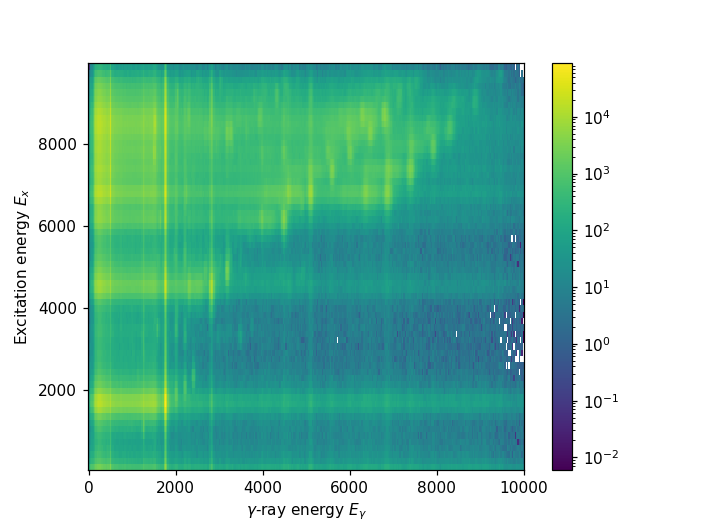

1621107.000000001
430674.0
333


In [3]:
%matplotlib notebook

# Reading the data 

#raw includes 28Si raw data + background
raw = om.Matrix(path="/home/vala/Downloads/h_Ex_Eg_28Si.m")

#Only background times back_gr_ratio:
bg = 1.2*om.Matrix(path="/home/vala/Downloads/h_Ex_Eg_bg_28Si.m")


# I use this cut since there is very little counts after:
raw.cut('Ex', 0, 10000)
raw.cut('Eg', 0, 10000)
bg.cut('Ex', 0, 10000)
bg.cut('Eg', 0, 10000)


# If I have finer binning the fbu gets very slow 
raw.rebin(axis= "Eg", factor=3)
bg.rebin(axis= "Eg", factor=3)

raw.plot()


raw_py, E = raw.projection(axis="Eg", Emin=1400, Emax=2200)
back_gr, E = bg.projection(axis="Eg", Emin=1400, Emax=2200) 


Eg = raw.Eg
print(np.sum(raw_py))
print(np.sum(back_gr))
print(len(Eg))

<IPython.core.display.Javascript object>


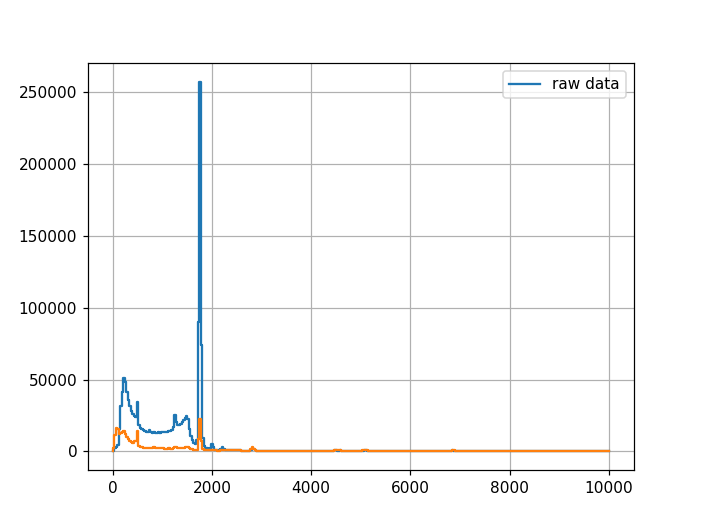

In [3]:
%matplotlib notebook
# Projected raw spectrum and background
plt.plot(Eg, raw_py,ls='steps', label='raw data')
plt.plot(Eg, back_gr, ls='steps')
plt.legend()
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


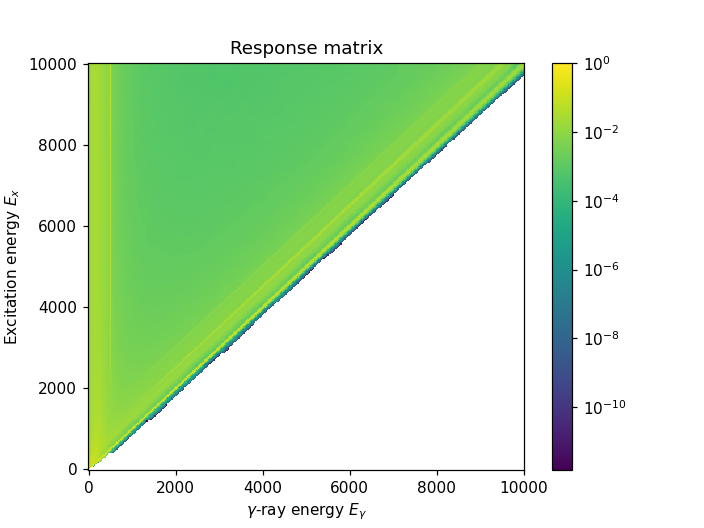

(<matplotlib.collections.QuadMesh at 0x7f946bc96790>,
 <Figure size 640x480 with 2 Axes>)

In [4]:
#Response matrix:
%matplotlib notebook

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 30 # (30/1330 = 2.25% )
folderpath = "/home/vala/Documents/Master/MachineLearning/ompy/OCL_response_functions/oscar2017_scale1.15"
response = om.Response(folderpath)

R_bay, R_tab_bay = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
# Magne recommends 1/10 of the actual resolution for unfolding purposes
R_bay_unf, R_tab_bay_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)

R_bay.plot(title="Response matrix", scale='log')

In [7]:
# Scaling the response with efficiency. 
eff = 0.5*R_tab_view["eff_tot"].values

pFE = R_tab_view['pFE'].values


resp =R_ompy_view.values*eff[:,np.newaxis] 

<IPython.core.display.Javascript object>


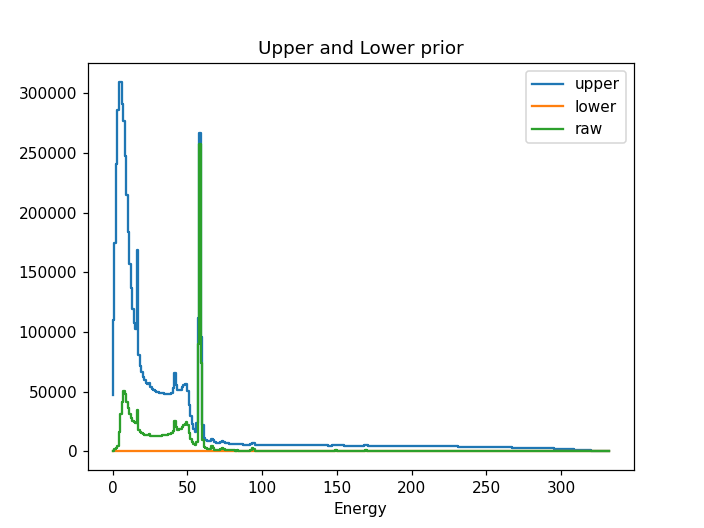

In [8]:
#Initiating priors upper and lower bound
%matplotlib notebook
prior_l = np.zeros(len(raw_py))
prior_u = raw_py/(eff*pFE) 

prior_u[58] +=30000
prior_u[59] += 300000
prior_u[60] +=30000
prior_u[61:]+=10000
plt.plot(prior_u@resp,ls='steps',markersize=2, label = 'upper')
plt.plot(prior_l@resp, ls='steps', label = 'lower')
plt.plot(raw_py, ls='steps', label= 'raw')
plt.title('Upper and Lower prior')
plt.xlabel('Energy')
plt.legend()
plt.show()  

In [9]:
#FBU: 
myfbu = fbu.PyFBU()

In [10]:
# FBU response
myfbu.response = resp
print(myfbu.response.shape)

(333, 333)


In [11]:
# FBU data and prior
myfbu.data =raw_py
myfbu.prior = 'Uniform'
myfbu.upper = prior_u  
myfbu.lower = prior_l

In [12]:
# Sampling and tuning
myfbu.nTune = 1000
myfbu.nMCMC = 5000
# Running posterior predictive check
myfbu.ppc = True
myfbu.nCores = 2

In [13]:
# Running FBU
myfbu.run()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


None


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [truth332, truth331, truth330, truth329, truth328, truth327, truth326, truth325, truth324, truth323, truth322, truth321, truth320, truth319, truth318, truth317, truth316, truth315, truth314, truth313, truth312, truth311, truth310, truth309, truth308, truth307, truth306, truth305, truth304, truth303, truth302, truth301, truth300, truth299, truth298, truth297, truth296, truth295, truth294, truth293, truth292, truth291, truth290, truth289, truth288, truth287, truth286, truth285, truth284, truth283, truth282, truth281, truth280, truth279, truth278, truth277, truth276, truth275, truth274, truth273, truth272, truth271, truth270, truth269, truth268, truth267, truth266, truth265, truth264, truth263, truth262, truth261, truth260, truth259, truth258, truth257, truth256, truth255, truth254, truth253, truth252, truth251, truth250, truth249, truth248, truth247, truth246, truth245, truth244, truth243, truth242, truth241, truth240, truth239, truth238, 

Elapsed 1:29:28 (2.24 samples/second)


In [14]:
# Getting the posterior predictive check
ppc = myfbu.post_pred


In [15]:
np.asarray(ppc['unfolded']).shape

(500, 333)

<IPython.core.display.Javascript object>


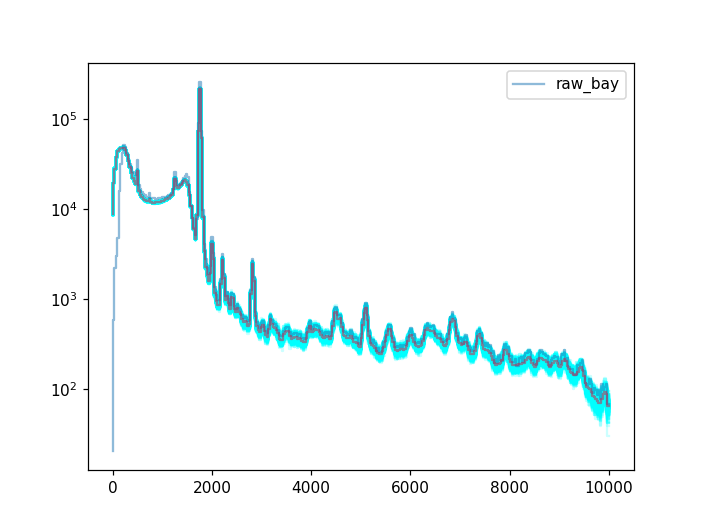

In [26]:
%matplotlib notebook
# Plotting the posterior predictive check with raw spectrum
post_array = np.asarray(ppc['unfolded'])


mean_post = np.mean(post_array, axis=0)

for i in range(len(post_array)):
    plt.plot(Eg, post_array[i], color="cyan", ls='steps', alpha=0.2)

plt.plot(Eg, raw_py,ls='steps', label='raw_bay', alpha=0.5)
plt.plot(Eg, mean_post, color='crimson', ls='steps', alpha=0.5)
plt.yscale('symlog')
plt.legend()
plt.show()

In [22]:
# Saving posterior predictive array to file 
cols = []
for i in range(len(post_array)):
    name = 'unfolded%d'%i
    
    cols.append(name)

df = pd.DataFrame(dict(zip(cols,post_array)))

df.to_csv('post_pred_check_1stEx_BG_300720.csv', index=False)